<a href="https://colab.research.google.com/github/js3lliott/yelp-reviews-data/blob/main/Yelp_Review_Sentiment_Analysis_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re
# import pyprind

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.decomposition import LatentDirichletAllocation

import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

stop = stopwords.words('english')
sia = SentimentIntensityAnalyzer()

print('Setup Complete') 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
Setup Complete


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
df = pd.read_csv('/content/reviews_sentiment.csv')
df.head()

,review_stars,text,rev_length,sentiment_score,sentiment
0,3,Decent food at reasonable prices. Ambiance is ...,57,-0.3182,neutral
1,4,"Good food, and good sized portions for the pri...",777,0.9392,positive
2,4,The name of the venue is intriguing but after ...,686,0.9700,positive
3,4,Really good Thai food. Had been looking a dece...,238,0.9243,positive
4,5,Bookmarked AND the hubby recommended it. Our f...,3392,0.9989,positive


In [ ]:
# going to replace and recalculate sentiments
df.drop(['review_stars', 'rev_length', 'sentiment_score', 'sentiment'], axis=1, inplace=True)

In [ ]:
def compound_score(txt):
  return sia.polarity_scores(txt)['compound']

def sentiment(score):
  emotion = ""
  if score >= 0:
    emotion = "positive"
  elif score < 0:
    emotion = "negative"
  return emotion

In [ ]:
polarity_scores = df['text'].astype("str").apply(compound_score)
df["sentiment_score"] = polarity_scores

df["sentiment"] = df["sentiment_score"].apply(sentiment)

In [ ]:
df.head()

,text,sentiment_score,sentiment
0,Decent food at reasonable prices. Ambiance is ...,-0.3182,negative
1,"Good food, and good sized portions for the pri...",0.9392,positive
2,The name of the venue is intriguing but after ...,0.9700,positive
3,Really good Thai food. Had been looking a dece...,0.9243,positive
4,Bookmarked AND the hubby recommended it. Our f...,0.9989,positive


In [ ]:
df.sentiment.value_counts()

positive    375470
negative     51320
Name: sentiment, dtype: int64

In [ ]:
df.drop('sentiment_score', axis=1, inplace=True)

In [ ]:
df.shape

(426790, 2)

In [ ]:
from sklearn.preprocessing import LabelEncoder

lab_enc = LabelEncoder()
df['sentiment'] = lab_enc.fit_transform(df['sentiment'])

In [ ]:
df.sample(5)

,text,sentiment
20123,It is typical western Chinese food. I actually...,0
141466,Cute decor and tasty bubble tea! This Cambie l...,1
127291,The fast delivery was the only good thing. All...,1
94051,"LOVE their pizza, butter chicken and samosas. ...",1
173728,"Good local joint, yummy food.\nBut I agree wit...",1


In [ ]:
df.loc[184, 'text'][:1000]

"My favorite Greek food and pizza place in Burnaby by a long shot. Portions are huge. We order regularly and it's always consistent and delicious! The staff there are always great, and you can tell they genuinely take pride in what they do."

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
def preprocess_df(text):
    porter = PorterStemmer()
    text = text.lower() # convert to lowercase
    text = re.sub(r'[^a-zA-Z]', ' ', text) # remove all non-word characters
    # stem, tokenize and remove stop words
    text = ' '.join([porter.stem(word) for word in word_tokenize(text) if (word not in stop)])
    return text

In [ ]:
%%time
nltk.download('punkt')
df['text'] = df['text'].apply(preprocess_df)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
CPU times: user 12min 58s, sys: 2.26 s, total: 13min 1s
Wall time: 13min 2s


In [ ]:
df.sample(5)

,text,sentiment
88922,anoth sushi place lonsdal north vancouv bold m...,1
283518,indian hoe wall burnabi one favorit place indi...,1
202904,one memor italian meal ever definit one best r...,1
163370,favourit bbt place far decor horrend mean mone...,1
313901,place rate came high expect read review say 1 ...,1


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = df['text']
y = df['sentiment']
print(X.shape, y.shape)

(426790,) (426790,)


In [ ]:
# train set split
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.25, stratify=y, random_state=2022)

# test set and validation set split
X_test, X_valid, y_test, y_valid = train_test_split(X_rem, y_rem, test_size=0.15, random_state=2022)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_valid.shape, y_valid.shape)

(320092,) (320092,)
(90693,) (90693,)
(16005,) (16005,)


In [ ]:
%%time
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'clf__penalty': ['l1', 'l2'],
               'clf__C': [1.0, 10.0, 100.0]},
             {'vect__ngram_range': [(1, 1)],
              'vect__use_idf': [False],
              'vect__norm': [None],
              'clf__penalty': ['l1', 'l2'],
              'clf__C': [1.0, 10.0, 100.0]}
             ]

lr_tfidf = Pipeline([('vect', tfidf),
                     ('clf', LogisticRegression(random_state=2022, 
                                                solver='liblinear'))])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                        scoring='accuracy',
                        cv=7, verbose=2,
                        n_jobs=-1)

gs_lr_tfidf.fit(X_train, y_train)

Fitting 7 folds for each of 12 candidates, totalling 84 fits
CPU times: user 1min 19s, sys: 10.2 s, total: 1min 29s
Wall time: 1h 6min 16s


In [ ]:
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)

Best parameter set: {'clf__C': 1.0, 'clf__penalty': 'l1', 'vect__ngram_range': (1, 1)} 


In [ ]:
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

CV Accuracy: 0.936


In [ ]:
clf = gs_lr_tfidf.best_estimator_
print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.937


In [ ]:
tf_idf = TfidfVectorizer(ngram_range=(1, 1))
tf_idf.fit(X_train)
tfidf_X_train = tf_idf.transform(X_train)
tfidf_X_test = tf_idf.transform(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
log_reg = LogisticRegression(solver='liblinear', penalty='l1', C=1.0)
log_reg_model = log_reg.fit(tfidf_X_train, y_train)
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, log_reg_model.predict(tfidf_X_test))} - F1 Score: {f1_score(y_test, log_reg_model.predict(tfidf_X_test))}")

Logistic Regression Accuracy: 0.9373821573881116 - F1 Score: 0.9649368690766524


In [ ]:
feature_to_coef = {word: coef for word, coef in zip(tf_idf.get_feature_names(), log_reg.coef_[0])}

print("Best Positive Words")
for best_pos in sorted(feature_to_coef.items(),
                       key=lambda x: x[1],
                       reverse=True)[:15]:
  print(best_pos)

print("Best Negative Words")
for best_neg in sorted(feature_to_coef.items(),
                       key=lambda x: x[1])[:15]:
  print(best_neg)

Best Positive Words
('delici', 16.352070008512023)
('perfectli', 15.735720802398577)
('love', 14.85036664219216)
('perfect', 14.123033281971745)
('excel', 11.726669574100454)
('pretti', 11.582067027530991)
('great', 11.543361528233714)
('best', 11.520151021020672)
('awesom', 11.109166632339786)
('amaz', 11.072509329240892)
('delight', 10.24377725518955)
('definit', 10.222949427159412)
('friend', 9.7818255989123)
('beauti', 9.724955593121468)
('good', 9.388060589515398)
Best Negative Words
('worst', -11.898928772403268)
('disappoint', -10.63307347335443)
('disgust', -9.015853850707202)
('poor', -8.886162683860347)
('dead', -8.83403201260967)
('horribl', -8.651640775879482)
('rude', -8.456355806409245)
('hell', -8.39508861006444)
('kill', -8.217168546191498)
('murder', -8.20048088523466)
('terribl', -7.963398234901842)
('sad', -7.715390142625491)
('wors', -7.710178738720824)
('bad', -7.651424314970266)
('aw', -7.516870921455092)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
log_odds = log_reg.coef_[0]
coef_df = pd.DataFrame(log_odds, tf_idf.get_feature_names(), columns=['coef']).sort_values(by='coef', ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
coef_df[:5]

,coef
delici,16.352070
perfectli,15.735721
love,14.850367
perfect,14.123033
excel,11.726670


In [ ]:
coef_df[-5:]

,coef
dead,-8.834032
poor,-8.886163
disgust,-9.015854
disappoint,-10.633073
worst,-11.898929


In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
svc = LinearSVC()
svc_model = svc.fit(tfidf_X_train, y_train)
print(f"SVC Accuracy: {accuracy_score(y_test, svc_model.predict(tfidf_X_test))} - F1 Score: {f1_score(y_test, svc_model.predict(tfidf_X_test))}")

SVC Accuracy: 0.9335670889704828 - F1 Score: 0.9627615192064033


In [ ]:
%%time
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [{'vect__ngram_range': [(1, 1)],
               'svc__C': [1.0, 10.0, 100.0],
               'svc__penalty': ['l1', 'l2']},
             {'vect__ngram_range': [(1, 1)],
              'vect__use_idf': [False],
              'vect__norm': [None],
              'svc__C': [1.0, 10.0, 100.0],
              'svc__penalty': ['l1', 'l2']}
             ]

svc_tfidf = Pipeline([('vect', tfidf),
                     ('svc', LinearSVC(loss='hinge', random_state=2022))])

gs_svc_tfidf = GridSearchCV(svc_tfidf, param_grid,
                        scoring='accuracy',
                        cv=7, verbose=2,
                        n_jobs=-1)

gs_svc_tfidf.fit(X_train, y_train)

Fitting 7 folds for each of 12 candidates, totalling 84 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
42 fits failed out of a total of 84.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/svm/_classes.py", line 272, in fit
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/s

CPU times: user 1min 7s, sys: 7.45 s, total: 1min 15s
Wall time: 41min 40s


In [ ]:
print('Best parameter set: %s ' % gs_svc_tfidf.best_params_)

Best parameter set: {'svc__C': 1.0, 'svc__penalty': 'l2', 'vect__ngram_range': (1, 1)} 


In [ ]:
print('CV Accuracy: %.3f' % gs_svc_tfidf.best_score_)

CV Accuracy: 0.934


In [ ]:
clf_svc = gs_svc_tfidf.best_estimator_
print('Test accuracy: %.3f' % clf_svc.score(X_test, y_test))

Test accuracy: 0.936


In [ ]:
clf_lr_pred = gs_lr_tfidf.best_estimator_.predict(X_test)
accuracy_score(y_test, clf_lr_pred)

0.9373821573881116

In [ ]:
clf_svc_pred = gs_svc_tfidf.best_estimator_.predict(X_test)
accuracy_score(y_test, clf_svc_pred)

0.9355297542257948

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

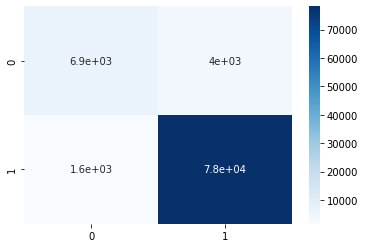

In [ ]:
conf_mat_lr = confusion_matrix(y_test, clf_lr_pred)
conf_mat_svc = confusion_matrix(y_test, clf_svc_pred)

sns.heatmap(conf_mat_lr, annot=True, cmap='Blues')
plt.show();

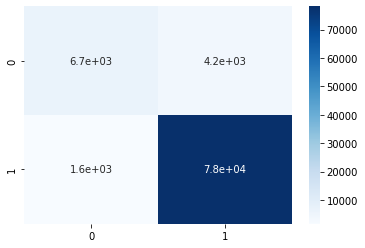

In [ ]:
sns.heatmap(conf_mat_svc, annot=True, cmap='Blues');

Now I know that I did it wrong by by using the `X_valid` and `y_valid` as the final test sets instead of using the `X_test` & `y_test` but it still does the same job, I just named them improperly.

In [ ]:
# Now predicting on validation set

final_lr_clf = gs_lr_tfidf.best_estimator_.predict(X_valid)
accuracy_score(y_valid, final_lr_clf)

0.934333020930959

In [ ]:
final_svc_clf = gs_svc_tfidf.best_estimator_.predict(X_valid)
accuracy_score(y_valid, final_svc_clf)

0.9320837238363011

In [ ]:
import pickle

In [ ]:
# save trained models to .pkl files

pickle.dump(log_reg_model, open("log_reg.pkl", "wb"))

In [ ]:
pickle.dump(svc_model, open("svc.pkl", "wb"))

In [ ]:
loaded_log_reg_model = pickle.load(open("log_reg.pkl", "rb"))
log_reg_y_new = loaded_log_reg_model.predict(X_test)
accuracy_score(y_test, log_reg_y_new)

ValueError: ignored